In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import scipy, os
from sklearn.metrics import confusion_matrix
import seaborn as sns

import sys
sys.path.append('../../Share/')
sys.path.append('../../Share/Manual_processing/')
import baseline, config, Model, utils, Same_with_MATLAB, Feature_info

import warnings
warnings.filterwarnings('ignore')


def restore_labels(mat, labels_windowed):

    original_length = mat['Data_ADC'].shape[1]
    win_size = 600 #Original
    win_step = 120
    valid_length = original_length - 2 * 60

    label_full = np.zeros(original_length, dtype=labels_windowed.dtype) # 복원될 시계열 레이블 (원본 길이)

    # 슬라이딩 윈도우 인덱스 따라 레이블 채워넣기
    for i, label in enumerate(labels_windowed):
        start = 60 + i * win_step
        end = start + win_size
        if end <= original_length - 60:
            label_full[start:end] = label

    return label_full


def filtering_zero(X, y, erase_label):
    # 1. erase_label 제거
    keep_indices = y != erase_label
    X = X[keep_indices]
    y = y[keep_indices]

    # 2. erase_label보다 큰 값은 1씩 감소
    y = np.where(y > erase_label, y - 1, y)

    return X, y

def vis_graph(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

def heatmap_confusion_matrix(X_test, y_test, model):
    # Predict class labels on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)  # convert softmax probs to predicted class
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(y_test)+1), yticklabels=range(np.max(y_test)+1))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


from collections import Counter

def balance_data(X, y):
    # Count samples per class
    class_counts = Counter(y)
    min_count = min(class_counts.values())  # target: balance all to minority count

    indices_list = []

    for label in sorted(class_counts.keys()):
        label_indices = np.where(y == label)[0]
        selected_indices = np.random.choice(label_indices, size=min_count, replace=False)
        indices_list.extend(selected_indices)

    # Shuffle all selected indices
    balanced_indices = np.random.permutation(indices_list)

    # Subset the data
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    return X_balanced, y_balanced


In [2]:
fs, lower_cutoff, upper_cutoff = Feature_info.fs, Feature_info.lower_cutoff, Feature_info.upper_cutoff
# fs, lower_cutoff, upper_cutoff = Feature_info.fs, 1, 300
filter_b, filter_a = Same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

In [3]:
def return_X_y(path):
    data_per_class_files = os.listdir(path)
    X, y = [], []

    for cls in data_per_class_files:
        input_path = path+cls+'/'
        files = os.listdir(input_path)
        mat = scipy.io.loadmat(input_path+files[0])
        label = mat['Data_Cls'].reshape(-1)  # shape: (1, 1729)

        feat_mean = np.tile(Feature_info.feat_mean_lst, (4, 1))
        feat_std = np.tile(Feature_info.feat_std_lst, (4, 1))

        mapped_label = np.where(label == 0, 0, int(cls))
        restored_label = restore_labels(mat, mapped_label)

        #print(mat['Data_ADC'].shape, mat['Data_Cls'].shape, restored_label.shape)
        extractor = Same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=True, num_feature_set=14) #I tried 23, but not so good
        extractor.buffer = mat['Data_ADC']
        #1000, 50 = winsize and winstep
        features, labels = extractor.extract_features_with_labels(win_size=1000, win_step=50, feat_exclude=25, filtering=False, restored_label=restored_label) #Same with
        #features, labels = extractor.extract_features_with_labels(win_size=1000, win_step=50, feat_exclude=25, filtering=True, restored_label=restored_label)

        features = np.transpose(features, (2, 0, 1))  # shape: (1729, 4, 14)
        X.append(features)
        y.append(labels)
        #print(features.shape, labels.shape)

    X_train = np.concatenate(X, axis=0)
    y_train = np.concatenate(y, axis=0)
    X_train = X_train[:, :, :, np.newaxis]
    print(pd.Series(y_train).value_counts())
    print(X_train.shape, y_train.shape)

    return X_train, y_train


def train_model_feature_wise(X_train, y_train, X_test, y_test):
    X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
    X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)
    ACC_lst = []

    for feature_idx in [2, 10]:
        One_X_train = X_train[:, :, feature_idx, :]
        One_X_test = X_test[:, :, feature_idx, :]

        model = Model.Original_model_1DCNN(One_X_train.shape[1:], num_class=np.max(y_train)+1)

        history, model = Model.Train_model(
            model, One_X_train, y_train, One_X_test, y_test,
            set_epoch=200, set_batch_size=256, Model_name='V0',
            set_verbose=False, save_model_set=False
        )
        ACC_lst.append(np.max(history.history['val_accuracy']))
        #vis_graph(history)
        #print("\n\n")
        #heatmap_confusion_matrix(One_X_test, y_test, model)

def train_model(X_train, y_train, X_test, y_test):
    X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
    X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)

    model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

    history, model = Model.Train_model(
        model, X_train, y_train, X_test, y_test,
        set_epoch=100, set_batch_size=256, Model_name='V0',
        set_verbose=False, save_model_set=False
    )
    vis_graph(history)
    heatmap_confusion_matrix(X_test, y_test, model)

# ENG - Ninapro data

0    28686
4      714
2      684
3      671
6      664
1      629
8      611
5      610
7      595
Name: count, dtype: int64
(33864, 4, 14, 1) (33864,)
0    28661
1      720
8      716
4      680
7      591
3      575
5      569
6      558
2      539
Name: count, dtype: int64
(33609, 4, 14, 1) (33609,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 23.39%
Maximum validation accuracy : 21.02%


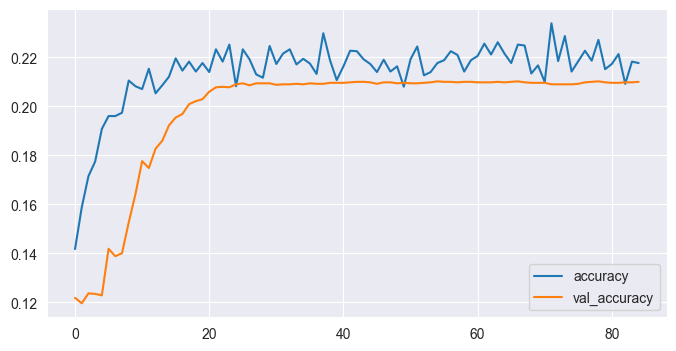

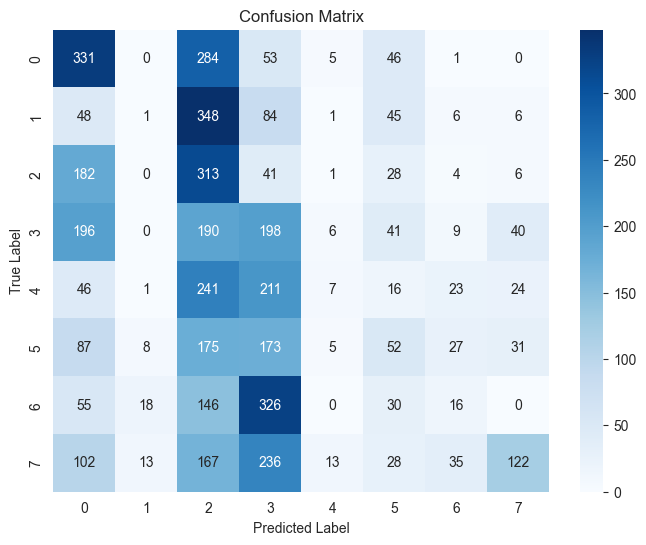

In [4]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_ninapro_class/E9AD0E7DCC2B/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_ninapro_class_v2/E9AD0E7DCC2B/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

0    28661
1      720
8      716
4      680
7      591
3      575
5      569
6      558
2      539
Name: count, dtype: int64
(33609, 4, 14, 1) (33609,)
0    28686
4      714
2      684
3      671
6      664
1      629
8      611
5      610
7      595
Name: count, dtype: int64
(33864, 4, 14, 1) (33864,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 23.79%
Maximum validation accuracy : 20.63%


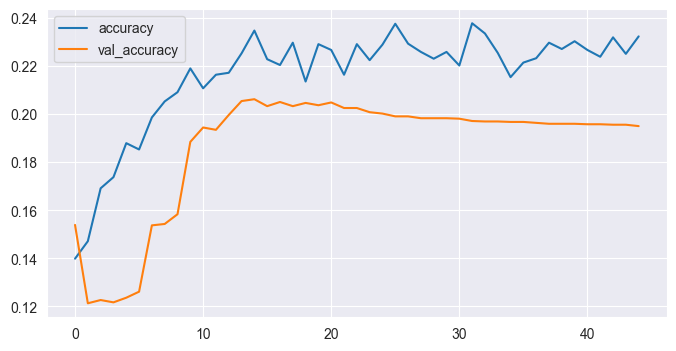

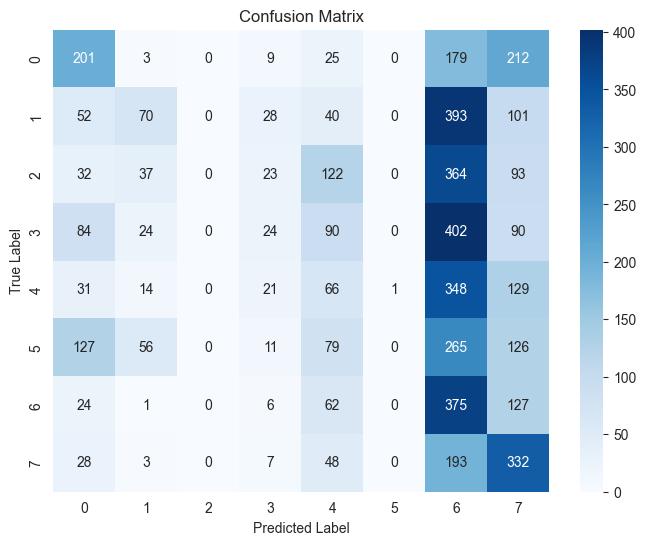

In [5]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_ninapro_class_v2/E9AD0E7DCC2B/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_ninapro_class/E9AD0E7DCC2B/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

# ENG - original class

0    18089
2      658
4      648
3      639
5      605
1      576
Name: count, dtype: int64
(21215, 4, 14, 1) (21215,)
0    18224
3      631
5      592
2      578
1      577
4      562
Name: count, dtype: int64
(21164, 4, 14, 1) (21164,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 52.18%
Maximum validation accuracy : 21.9%


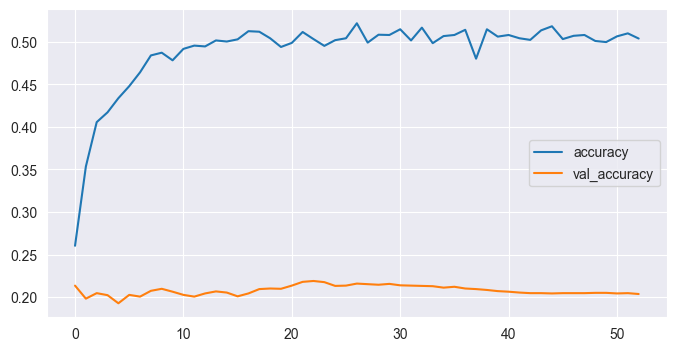

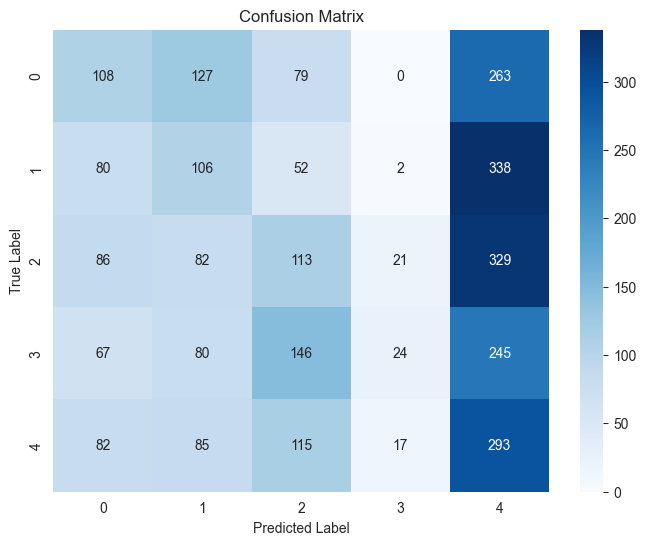

In [6]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_original_class/E9AD0E7DCC2B/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_original_class_v2/E9AD0E7DCC2B/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

0    18224
3      631
5      592
2      578
1      577
4      562
Name: count, dtype: int64
(21164, 4, 14, 1) (21164,)
0    18089
2      658
4      648
3      639
5      605
1      576
Name: count, dtype: int64
(21215, 4, 14, 1) (21215,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 23.4%
Maximum validation accuracy : 22.17%


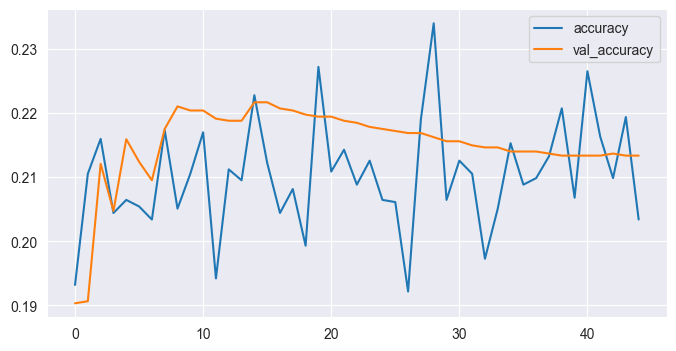

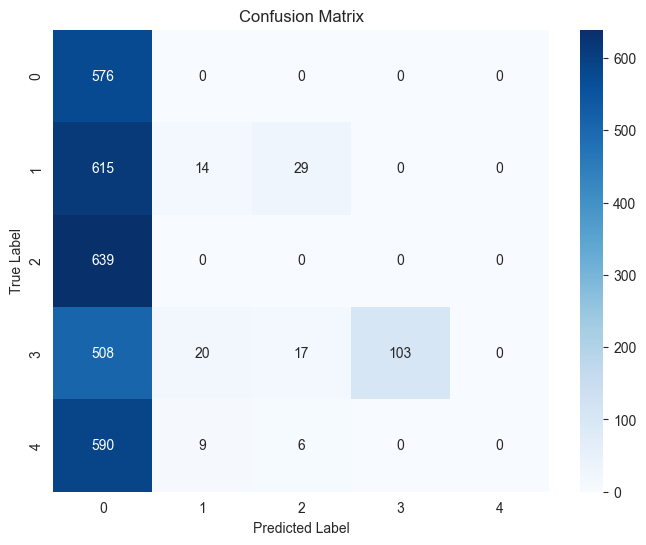

In [7]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_original_class_v2/E9AD0E7DCC2B/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_ENG_original_class/E9AD0E7DCC2B/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

# EMG - Ninapro

0    28124
2      823
3      773
8      768
4      745
5      732
1      718
7      707
6      626
Name: count, dtype: int64
(34016, 4, 14, 1) (34016,)
0    27645
3      949
5      848
4      844
2      840
8      821
1      763
7      762
6      554
Name: count, dtype: int64
(34026, 4, 14, 1) (34026,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 22.81%
Maximum validation accuracy : 17.94%


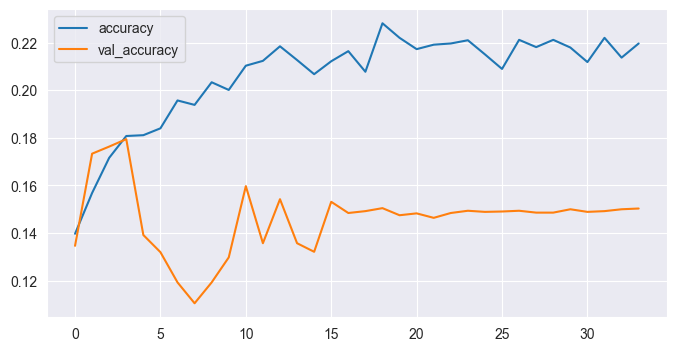

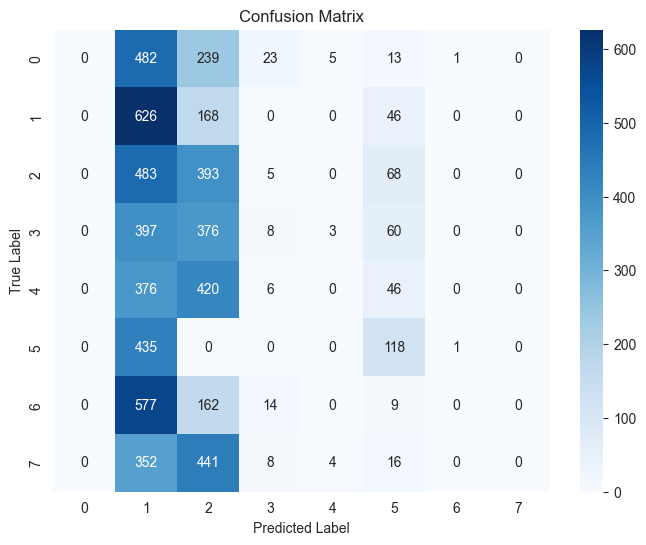

In [8]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_ninapro_class/E8DD80E550BB/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_ninapro_class_v2/E8DD80E550BB/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

0    27645
3      949
5      848
4      844
2      840
8      821
1      763
7      762
6      554
Name: count, dtype: int64
(34026, 4, 14, 1) (34026,)
0    28124
2      823
3      773
8      768
4      745
5      732
1      718
7      707
6      626
Name: count, dtype: int64
(34016, 4, 14, 1) (34016,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 20.67%
Maximum validation accuracy : 20.81%


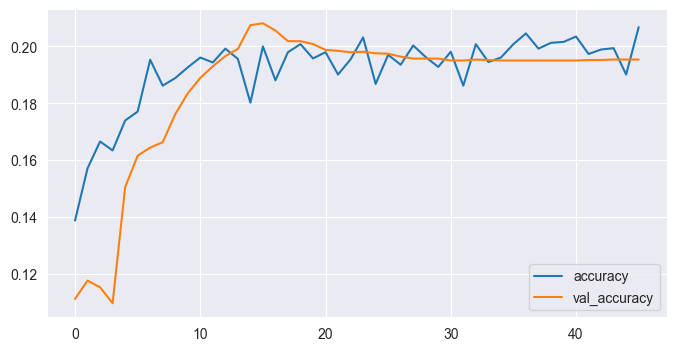

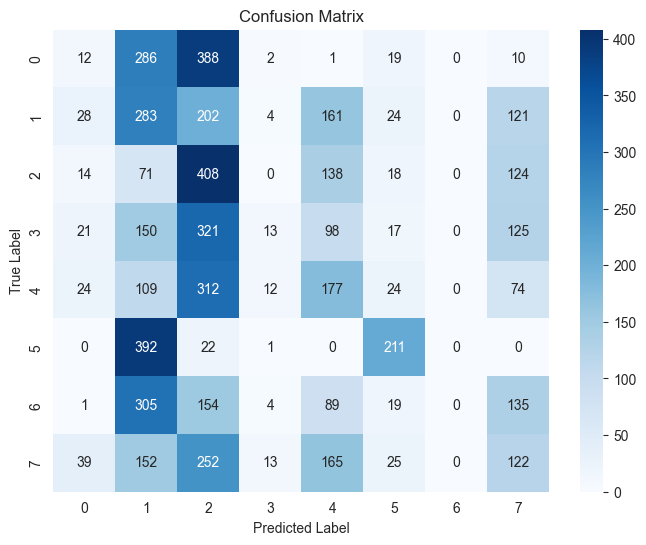

In [9]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_ninapro_class_v2/E8DD80E550BB/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_ninapro_class/E8DD80E550BB/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

# EMG - Original Class

0    17516
4      999
1      788
5      711
3      700
2      551
Name: count, dtype: int64
(21265, 4, 14, 1) (21265,)
0    17521
4     1004
5      872
3      675
1      630
2      553
Name: count, dtype: int64
(21255, 4, 14, 1) (21255,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 60.76%
Maximum validation accuracy : 47.46%


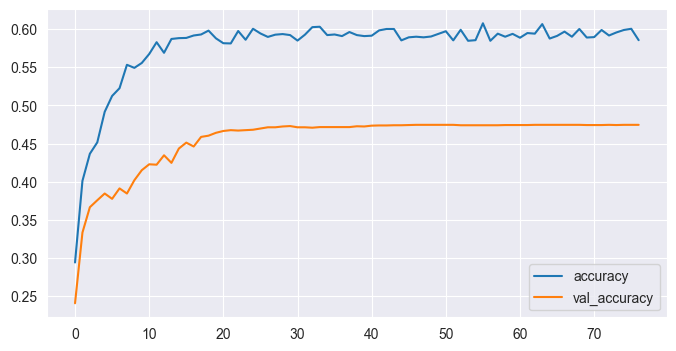

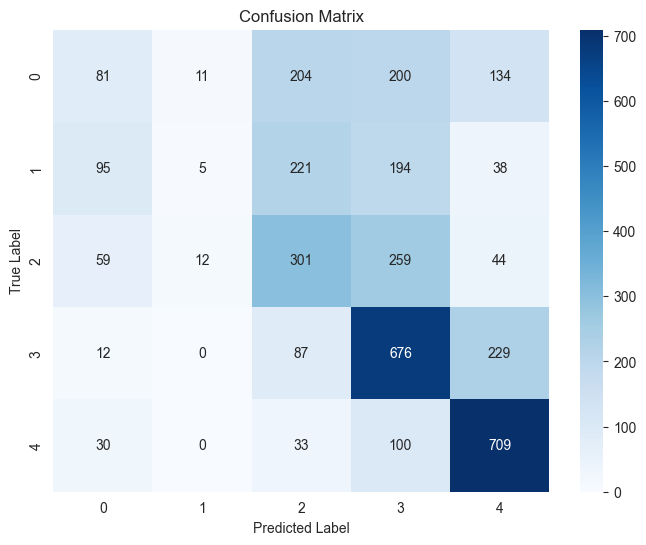

In [10]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_original_class/E8DD80E550BB/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_original_class_v2/E8DD80E550BB/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

0    17521
4     1004
5      872
3      675
1      630
2      553
Name: count, dtype: int64
(21255, 4, 14, 1) (21255,)
0    17516
4      999
1      788
5      711
3      700
2      551
Name: count, dtype: int64
(21265, 4, 14, 1) (21265,)
Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 46.12%
Maximum validation accuracy : 45.72%


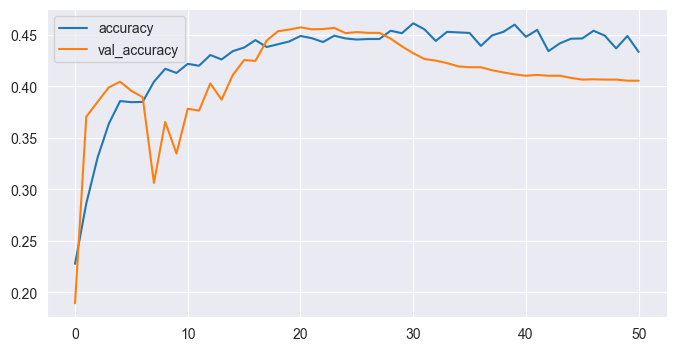

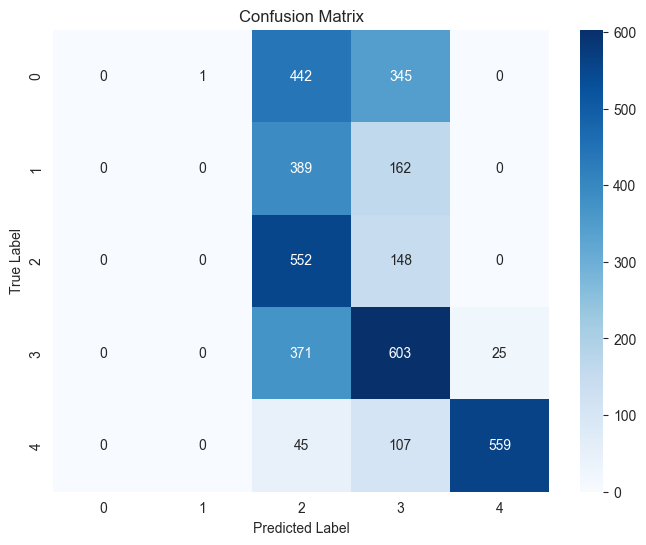

In [11]:
X_train, y_train = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_original_class_v2/E8DD80E550BB/raw/')
X_test, y_test = return_X_y(path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-04_EMG_original_class/E8DD80E550BB/raw/')

#train_model_feature_wise(X_train, y_train, X_test, y_test)
train_model(X_train, y_train, X_test, y_test)

ENG
- Ninapro Class (8) : 21%
- Original Class (5) : 22%

EMG:
- Ninapro Class (8) : 19%
- Original Class (5) : 46%
